<a href="https://colab.research.google.com/github/greyhound101/Multihead_attention/blob/master/concatenate_add.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
fnl_acc3=list(np.load('/content/final_accuracy_all_fold1_final_final_145.npy',allow_pickle=True).item().values())[0]
fnl_acc5=list(np.load('/content/final_accuracy_all_fold2_final_final_145.npy',allow_pickle=True).item().values())[0]
fnl_acc4=list(np.load('/content/final_accuracy_last_fold3_1e-4_wn.npy',allow_pickle=True).item().values())[0]
fnl_acc2=list(np.load('/content/final_accuracy_last_fold4_5e-4_wn.npy',allow_pickle=True).item().values())[0]
fnl_acc1=list(np.load('/content/final_accuracy_last_fold5_1e-4_wn.npy',allow_pickle=True).item().values())[0]
np.mean([fnl_acc1,fnl_acc2,fnl_acc3,fnl_acc4,fnl_acc5])

0.9679440573918517

In [ ]:
fnl_acc3=list(np.load('/content/times_last_fold3_1e-4_wn.npy',allow_pickle=True).item().values())[0]
fnl_acc4=list(np.load('/content/times_last_fold4_5e-4_wn.npy',allow_pickle=True).item().values())[0]
fnl_acc5=list(np.load('/content/times_last_fold5_1e-4_wn.npy',allow_pickle=True).item().values())[0]
fnl_acc2=list(np.load('/content/times_all_fold_2_final_final_145.npy',allow_pickle=True).item().values())[0]
fnl_acc1=list(np.load('/content/times_all_fold_1_final_final_145.npy',allow_pickle=True).item().values())[0]
np.mean([fnl_acc1,fnl_acc2,fnl_acc3,fnl_acc4,fnl_acc5])

6567.962405538559

In [ ]:
tot_ans=[]
tot_pre=[]

In [ ]:


from sklearn.metrics import confusion_matrix
ans_1=np.load('/content/answers_all_fold_1_final_final_145.npy',allow_pickle=True).item()
fold_1_pre=np.load('/content/predictions_all_fold_1_final_final_145.npy',allow_pickle=True).item()
ans_1=list(ans_1.values())[0]
fold_1_pre=list(fold_1_pre.values())[0]
tot_ans.extend(ans_1)
tot_pre.extend(fold_1_pre)
print(confusion_matrix(ans_1,fold_1_pre))



[[112   0   0]
 [  2 241   2]
 [  5   2 178]]


In [ ]:

ans_1=np.load('/content/answers_all_fold_2_final_final_145.npy',allow_pickle=True).item()
fold_1_pre=np.load('/content/predictions_all_fold_2_final_final_145.npy',allow_pickle=True).item()
ans_1=list(ans_1.values())[0]
fold_1_pre=list(fold_1_pre.values())[0]
tot_ans.extend(ans_1)
tot_pre.extend(fold_1_pre)
print(confusion_matrix(ans_1,fold_1_pre))



[[112   0   0]
 [  2 241   2]
 [  5   2 178]]


In [ ]:

ans_1=np.load('/content/answers_last_fold3_1e-4_wn.npy',allow_pickle=True).item()
fold_1_pre=np.load('/content/predictions_last_fold3_1e-4_wn.npy',allow_pickle=True).item()
ans_1=list(ans_1.values())[0]
fold_1_pre=list(fold_1_pre.values())[0]
tot_ans.extend(ans_1)
tot_pre.extend(fold_1_pre)
print(confusion_matrix(ans_1,fold_1_pre))



[[133   4   2]
 [ 12 219   0]
 [  2   0 200]]


In [ ]:

ans_1=np.load('/content/answers_last_fold4_5e-4_wn.npy',allow_pickle=True).item()
fold_1_pre=np.load('/content/predictions_last_fold4_5e-4_wn.npy',allow_pickle=True).item()
ans_1=list(ans_1.values())[0]
fold_1_pre=list(fold_1_pre.values())[0]
tot_ans.extend(ans_1)
tot_pre.extend(fold_1_pre)
print(confusion_matrix(ans_1,fold_1_pre))



[[112   9   3]
 [  0 324   1]
 [  5   2 172]]


In [ ]:

ans_1=np.load('/content/answers_last_fold5_1e-4_wn.npy',allow_pickle=True).item()
fold_1_pre=np.load('/content/predictions_last_fold5_1e-4_wn.npy',allow_pickle=True).item()
ans_1=list(ans_1.values())[0]
fold_1_pre=list(fold_1_pre.values())[0]
tot_ans.extend(ans_1)
tot_pre.extend(fold_1_pre)
print(confusion_matrix(ans_1,fold_1_pre))



[[141   6  19]
 [  5 281   1]
 [  1   2 187]]


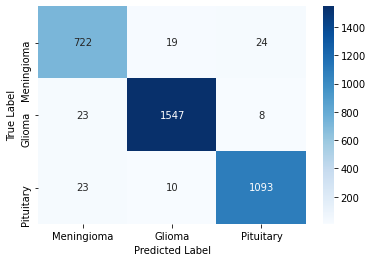

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.heatmap(confusion_matrix(tot_ans,tot_pre),annot=True,cmap='Blues', fmt='g',xticklabels=['Meningioma', 'Glioma','Pituitary' ],yticklabels=['Meningioma', 'Glioma','Pituitary' ])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('mobilenet.png')

In [ ]:

history={}
history['fold1']=np.load('/content/history_all_fold_1_final_final_145.npy',allow_pickle=True).item()
history['fold2']=np.load('/content/history_all_fold_2_final_final_145.npy',allow_pickle=True).item()
history['fold3']=np.load('/content/history_last_fold3_1e-4_wn.npy',allow_pickle=True).item()
history['fold4']=np.load('/content/history_last_fold4_5e-4_wn.npy',allow_pickle=True).item()
history['fold5']=np.load('/content/history_last_fold5_1e-4_wn.npy',allow_pickle=True).item()



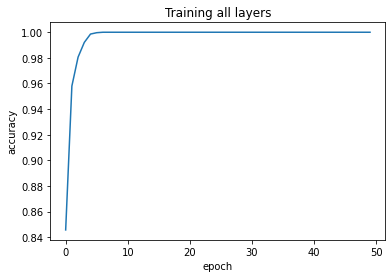

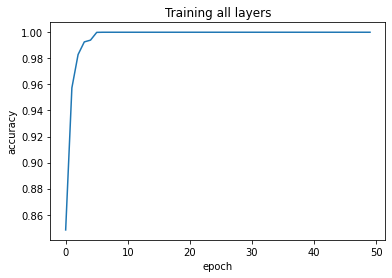

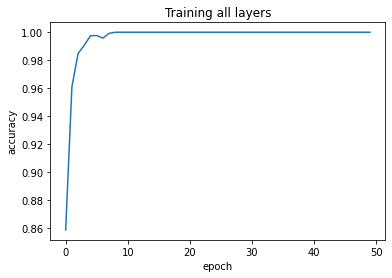

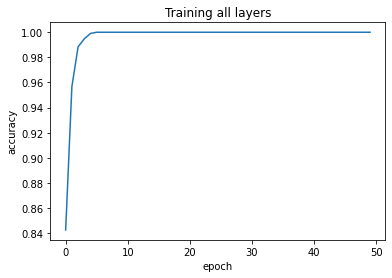

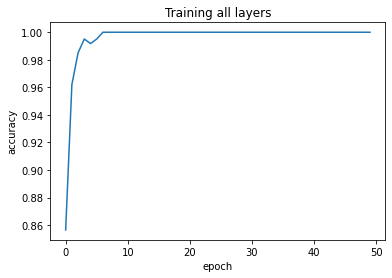

In [ ]:
from matplotlib import pyplot as plt
for i in range(5):
    fold='fold'+str(i+1)
    fold1='fold_'+str(i+1)
    plt.plot(history[fold][fold1]['accuracy'])
    plt.title('loss for fold '+str(i))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Training all layers')
    plt.show()

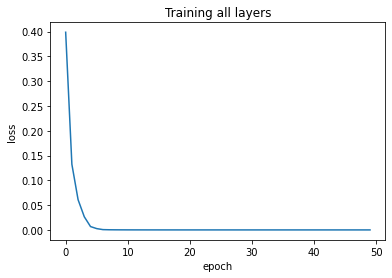

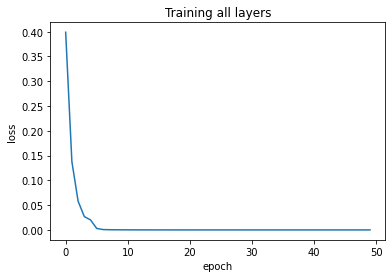

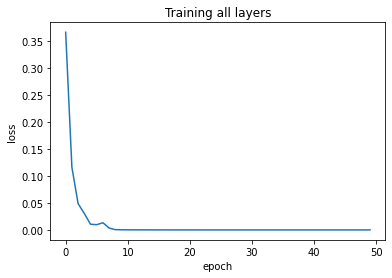

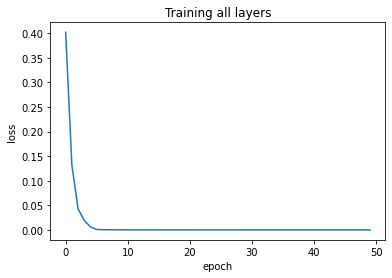

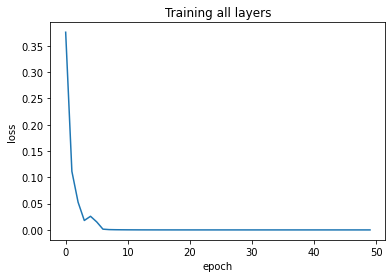

In [ ]:
from matplotlib import pyplot as plt
for i in range(5):
    fold='fold'+str(i+1)
    fold1='fold_'+str(i+1)
    plt.plot(history[fold][fold1]['loss'])
    plt.title('loss for fold '+str(i))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training all layers')
    plt.show()